In [1]:
from matplotlib.pyplot import hist, show
from collections import Counter
import urllib
import codecs
from nltk.stem import WordNetLemmatizer

## Czytania danego dnia

In [2]:
#downloading the webpage
import requests
import datetime

now = datetime.datetime.now()
year = str(now.year)
month = str(now.month)
if len(month) == 1:
    month = "0" + month
day = str(now.day)
ymd = year+month+day

    
address = "http://mateusz.pl/czytania/" + year + "/" + ymd + ".html"
#address = "http://mateusz.pl/czytania/2018/20180909.html" #niedziela
page = requests.get(address)

In [3]:
#parsing a page
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

In [4]:
#print(soup.prettify()) 
#Exception handling for more readings
try:
    section = list(soup.children)[9]
    section_content = section.find_all('p')
except:
    section = soup.find_all('section')[0]
    section_content =section.find_all('p')

In [5]:
len(section_content)

7

In [6]:
pierwsze_czytanie = section_content[0]
pierwsze_czytanie

<p>(Prz 30, 5-9)<br/>
    Każde słowo Boże wypróbowane, tarczą jest dla tych, co się chronią do niego. Do słów Jego nic nie dodawaj, by cię nie skarcił i zostałbyś kłamcą. Proszę Cię o dwie rzeczy, nie odmawiaj mi, nim umrę: Fałsz i kłamstwo oddal ode mnie, nie dawaj mi bogactwa ni nędzy, żyw mnie chlebem niezbędnym, bym syty, nie stał się niewierny i nie rzekł: "A któż to jest Pan?" lub z biedy nie zaczął kraść i nie targnął się na imię mego Boga.</p>

In [7]:
ewangelia = section_content[len(section_content)-1]
ewangelia

<p>(Łk 9, 1-6)<br/>
		Jezus zwołał Dwunastu, dał im moc i władzę nad wszystkimi złymi duchami oraz władzę leczenia chorób. I wysłał ich, aby głosili królestwo Boże i uzdrawiali chorych. Mówił do nich: "Nie bierzcie nic na drogę: ani laski, ani torby podróżnej, ani chleba, ani pieniędzy; nie miejcie też po dwie suknie. Gdy do jakiegoś domu wejdziecie, pozostańcie tam i stamtąd będziecie wychodzić. Jeśliby was gdzieś nie przyjęli, wychodząc z tego miasta, strząśnijcie proch z nóg waszych na świadectwo przeciwko nim!" Wyszli więc i chodzili po wsiach, głosząc Ewangelię i uzdrawiając wszędzie.</p>

## Noise removal

In [8]:
import re
text = str(ewangelia)

def clean_html(raw):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, '', raw)
    return cleantext

def clean_proverbs (raw):
    cleaner = re.compile('\([^)]*\)')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_indent(raw):
    cleaner = re.compile('^\s+')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_text(raw):
    text = clean_html(raw)
    text = clean_proverbs(text)
    text = clean_indent(text)
    return text

In [9]:
clean_text = clean_text(text)
clean_text

'Jezus zwołał Dwunastu, dał im moc i władzę nad wszystkimi złymi duchami oraz władzę leczenia chorób. I wysłał ich, aby głosili królestwo Boże i uzdrawiali chorych. Mówił do nich: "Nie bierzcie nic na drogę: ani laski, ani torby podróżnej, ani chleba, ani pieniędzy; nie miejcie też po dwie suknie. Gdy do jakiegoś domu wejdziecie, pozostańcie tam i stamtąd będziecie wychodzić. Jeśliby was gdzieś nie przyjęli, wychodząc z tego miasta, strząśnijcie proch z nóg waszych na świadectwo przeciwko nim!" Wyszli więc i chodzili po wsiach, głosząc Ewangelię i uzdrawiając wszędzie.'

## Tokenization & Segmentation

In [10]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = clean_text

In [11]:
sentences = sent_tokenize(text)
#sentences

In [12]:
tokens = word_tokenize(text)
lower_tokens = [t.lower() for t in tokens]
#lower_tokens

## Normalization

#### Lemmatyzacja (lemmatisation) 
Algorytm znajdowania lemmy, formy podstawowej wyrazu w obszarze części mowy którą reprezentuje. Inaczej: wyszukiwanie formy kanonicznej leksemu. W komputerowej analizie języka naturalnego lemmatyzacja jest operacją bardziej precyzyjną niż stemmatyzacja. 

#### Stemmatyzacja (stemming) 
Sprowadzenie wyrazu reprezentującego dowolną część mowy do stemu, rdzenia postaci źródłowej, najczęściej rzeczownika, bądź niekiedy nawet sekwencji znaków nie mającej samodzielnego znaczenia w języku naturalnym. 

In [13]:
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]
#alpha_only

In [14]:
polish_stops = codecs.open("polishStopWords",'r','utf-8')
ps = polish_stops.read().split('\n')
polish_stops.close()

In [15]:
# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in ps]
#no_stops

## Topic identification
To do:
- tf-idf
- Named-entity recognition

### Bag of words

In [16]:
bow = Counter(no_stops)

In [26]:
bow.most_common(10)

[('władzę', 2),
 ('jezus', 1),
 ('zwołał', 1),
 ('dwunastu', 1),
 ('dał', 1),
 ('moc', 1),
 ('wszystkimi', 1),
 ('złymi', 1),
 ('duchami', 1),
 ('leczenia', 1)]

### Word cloud

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

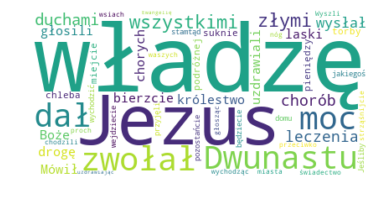

In [24]:
text = clean_text

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = ps, max_font_size=400, max_words=50, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Tf-idf 

#### Term frequency - inverse document frequency
Ważenie częstością termów - odwrotna częstość w dokumentach - jedna z metod obliczania wagi słów w oparciu o liczbę ich wystąpień, należąca do grupy algorytmów obliczających statystyczne wagi termów. 
- Każdy dokument reprezentowany jest przez wektor, składający się z wag słów występujących w tym dokumencie. 
- TFIDF informuje o częstości wystąpienia termów uwzględniając jednocześnie odpowiednie wyważenie znaczenia lokalnego termu i jego znaczenia w kontekście pełnej kolekcji dokumentów. 

https://pl.wikipedia.org/wiki/TFIDF

## Classification ?

### Other stuff

In [18]:
milujcie_sent = milujcie.read().split('\r\n')

NameError: name 'milujcie' is not defined

In [ ]:
song = ""
for sentence in milujcie_sent:
    song = song + sentence

In [ ]:
text = milosc.read()
#text = song

In [ ]:
milujcie = codecs.open("milujcie",'r','utf-8')